Get data.
try multiple clustering algorithms and pplot the profiles

In [1]:
import pandas, seaborn, numpy, pyensembl, scipy, os

import sklearn, sklearn.cluster
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4), 'axes.labelsize':20})

# 0. user-defined variables

In [2]:
up_file = '~/gd15/hi/research/osteo/results/up_and_down_DEGs/up.csv'
overall_file = '~/gd15/hi/research/osteo/results/up_and_down_DEGs/all_zscore.csv'
dorothea_regulons_dir = '/home/adrian/databases/dorothea/regulons/'

days = [3, 6, 9, 16, 28]

# 1. read data

## 1.1. read expression data

In [3]:
expression = pandas.read_csv(up_file, index_col=0)

print(expression.shape)
expression.head()

(571, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000106538,-1.041366,-0.637951,0.702163,-0.637951,1.615104
ENSG00000257017,-1.184086,-0.713912,0.881069,-0.438877,1.455807
ENSG00000112936,-1.270523,-0.691817,0.932816,-0.353296,1.382822
ENSG00000129988,-1.051535,-1.051535,1.257512,-0.229036,1.074594
ENSG00000133048,-1.784914,0.207845,1.236076,0.474520,-0.133526


In [4]:
overall_expression = pandas.read_csv(overall_file, index_col=0)

print(overall_expression.shape)
overall_expression.head()

(61881, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000000003,-1.652464,0.509438,1.011249,0.765363,-0.633587
ENSG00000000005,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,0.388132,-0.813199,-1.316938,1.555271,0.186734
ENSG00000000457,0.500000,0.500000,0.500000,0.500000,-2.000000
ENSG00000000460,1.648206,-0.777687,-0.777687,0.684855,-0.777687


## 1.2. read TF-gene interactions

In [5]:
regulons = {}
regulon_files = os.listdir(dorothea_regulons_dir)
for file in regulon_files:
    TF_name = file.split('.txt')[0]
    df = pandas.read_csv(dorothea_regulons_dir+file, sep='\t', header=None, names=['target'])
    targets = df['target'].to_list()
    regulons[TF_name] = targets

In [6]:
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

In [7]:
# 12 missing for annotation 75
# 9 missing for annotation 86
# 11 missing for annotation 100
# 11 missing for annotation 102
up_genes = expression.index.to_list()
rosetta_up_genes = {}

missing = 0
for ensembl in up_genes:
    try:
        gene_name = annotation.gene_by_id(ensembl).gene_name
        rosetta_up_genes[ensembl] = gene_name
    except:
        missing = missing + 1
        print('Missing #{}. {} not found'.format(missing, ensembl))

Missing #1. ENSG00000274619 not found
Missing #2. ENSG00000278843 not found
Missing #3. ENSG00000282854 not found
Missing #4. ENSG00000283009 not found
Missing #5. ENSG00000283106 not found
Missing #6. ENSG00000263238 not found
Missing #7. ENSG00000275482 not found
Missing #8. ENSG00000273707 not found
Missing #9. ENSG00000282147 not found


In [8]:
# define M, the number of target genes in Dorothea regulons
all_targets = []
for TF in regulons:
    for element in regulons[TF]:
        all_targets.append(element)
M = len(list(set(all_targets)))
print('found {} targets'.format(M))

found 20295 targets


# 2. format data

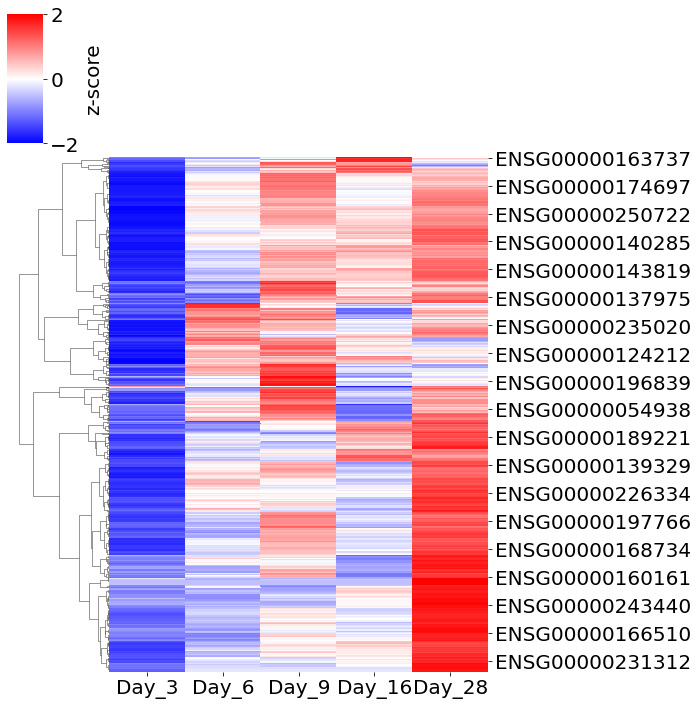

In [9]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(expression, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [10]:
x = expression.to_numpy()
x

array([[-1.04136554, -0.63795097,  0.70216321, -0.63795097,  1.61510426],
       [-1.18408635, -0.71391191,  0.88106904, -0.43887749,  1.45580671],
       [-1.27052345, -0.6918175 ,  0.93281551, -0.35329621,  1.38282165],
       ...,
       [-1.39939766, -0.23503204,  0.6681201 ,  1.50128656, -0.53497696],
       [ 0.78501372, -0.03377595, -0.03377595, -1.79471421,  1.0772524 ],
       [ 0.61327685, -0.6199899 ,  0.35890899, -1.59888878,  1.24669284]])

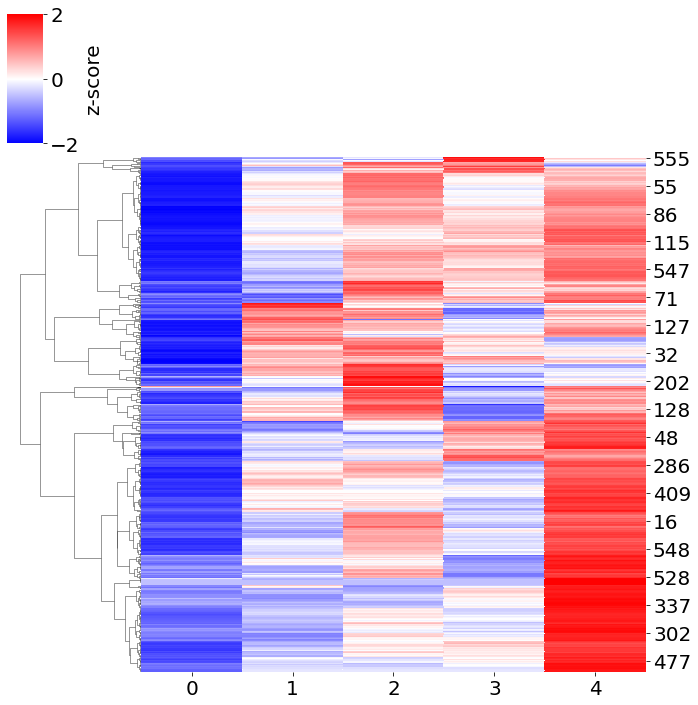

In [11]:
seaborn.clustermap(x, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. define partition range

In [12]:
number_elements = expression.shape[0]
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

28 114


# 4. learning

In [13]:
log = open('log.txt', 'w')

In [14]:
expression.head()

,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000106538,-1.041366,-0.637951,0.702163,-0.637951,1.615104
ENSG00000257017,-1.184086,-0.713912,0.881069,-0.438877,1.455807
ENSG00000112936,-1.270523,-0.691817,0.932816,-0.353296,1.382822
ENSG00000129988,-1.051535,-1.051535,1.257512,-0.229036,1.074594
ENSG00000133048,-1.784914,0.207845,1.236076,0.474520,-0.133526


In [15]:
def tf_enrichment(k, labels):
    
    domain = []; controllers = []
    
    for ki in range(k):
        
        indices = numpy.where(labels == ki)[0]
        log.write('\nCluster c{} with {} gene indices: {}\n'.format(ki, len(indices), indices))
        cluster = expression.iloc[indices, :]
        cluster_average = cluster.mean().values

        ###
        ### plotting
        ###
#         for gene in cluster.index:
#             matplotlib.pyplot.plot(days, cluster.loc[gene, :], 'o-')
#         matplotlib.pyplot.xlabel('Time (day)')
#         matplotlib.pyplot.ylabel('zscore')
#         matplotlib.pyplot.grid(alpha=0.5, ls=':')
#         matplotlib.pyplot.ylim([-2, 2])
#         matplotlib.pyplot.xlim(([0, 29]))
#         matplotlib.pyplot.title('k={} | c{}'.format(k, ki))
#         matplotlib.pyplot.tight_layout()
#         matplotlib.pyplot.show()

        ###
        ### convert cluster ENSEMBL ids into gene names
        ###
        cluster_ensembl_ids = expression.index[indices]
        cluster_gene_names = []
        for ensembl in cluster_ensembl_ids:
            try:
                gene_name = rosetta_up_genes[ensembl]
                cluster_gene_names.append(gene_name)
            except:
                log.write('ENSEMBL ID {} lost.\n'.format(ensembl))
        log.write('{}/{} genes recovered.\n'.format(len(cluster_gene_names), len(cluster_ensembl_ids)))


        ###
        ### enrichment
        ###

        # define N, the size of the regulon
        N = len(cluster_gene_names)

        # get all TFs regulating each target gene
        putative_TFs = []
        for gene_name in cluster_gene_names:
            for TF in regulons:
                if gene_name in regulons[TF]:
                    putative_TFs.append(TF)
        putative_regulators = list(set(putative_TFs))
        log.write('all possible regulators of this cluster:{}\n'.format(len(putative_regulators)))

        # hypergeometric test for putative regulators
        p_values_uncorrected = []
        hits_tracker = [] # stores tuples of number of targets and hits
        for putative_regulator in putative_regulators:

            # define n, the number of targets of that particular TF in Dorothea
            global_TF_targets = regulons[putative_regulator]
            n = len(global_TF_targets)
            #print(putative_regulator, n)

            # define x, the number of DETs that are targets of that particular TF
            intersect = list(set(cluster_gene_names) & set(global_TF_targets))
            x = len(intersect)

            # make sure that the regulon has at least two target genes for a given TF, otherwise, don't waste hypothesis correction
            if x >= 2:
                #print('\t {}/{}'.format(x, n))
                pvalue = scipy.stats.hypergeom.sf(x-1, M, n, N)
                p_values_uncorrected.append(pvalue)

                tracking_tuple = (putative_regulator, n, M, x, N, round(x/N, 3), intersect)
                hits_tracker.append(tracking_tuple)

        # multiple correction for all putative regulators of this cluster: Benjamini–Hochberg correction
        alternative, corrected_p_values = statsmodels.stats.multitest.fdrcorrection(p_values_uncorrected, alpha=0.1)
        for i in range(len(alternative)):
            if alternative[i] == True:
                
                # compute correlation
                try:
                    recovered_ids = annotation.genes_by_name(hits_tracker[i][0])
                    if len(recovered_ids) == 1:
                        tf_id = recovered_ids[0].gene_id
                    else:
                        raise ValueError('two found')
                    #print(recovered_ids)
                    #print(tf_id)
                    tf_trend = overall_expression.loc[tf_id, :].values
                    pcc, pvalue = scipy.stats.pearsonr(cluster_average, tf_trend)
                except:
                    pcc = 0            
                
                if pcc > 0.8:
                    log.write('HIT: {} {}\n'.format(round(pcc, 3), hits_tracker[i]))
                    
                    controllers.append(hits_tracker[i][0])
                    for element in hits_tracker[i][-1]:
                        domain.append(element)
                    
                        
    # compute the domain
    unique_domain = list(set(domain))
    domain_size = len(unique_domain)
    
    unique_controllers = list(set(controllers))
    controllers_size = len(unique_controllers)
                
    return domain_size, controllers_size

In [16]:
k_range = range(30, 50+1)

In [17]:
p_ss = []; p_khi = []; p_dbi = []; p_dom = []; p_control = []

for k in k_range:
    
    log.write('WORKING WITH k={}\n'.format(k))

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    
    domain_size, controllers_size = tf_enrichment(k, labels)
    
    p_dom.append(domain_size)
    p_control.append(controllers_size)

In [18]:
log.close()

In [19]:
# need to do with K means and all other methods present in sklearn that are inductive (?)

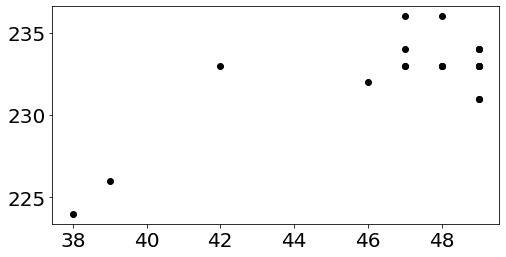

In [20]:
matplotlib.pyplot.plot(p_control, p_dom, 'ok')

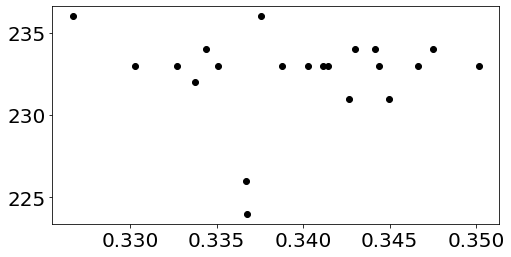

In [21]:
matplotlib.pyplot.plot(p_ss, p_dom, 'ok')

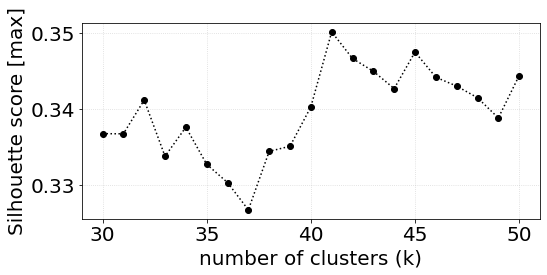

In [22]:
matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()

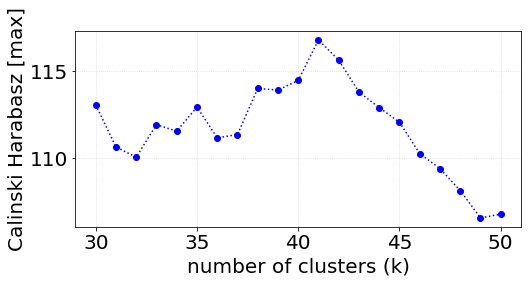

In [23]:
matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()

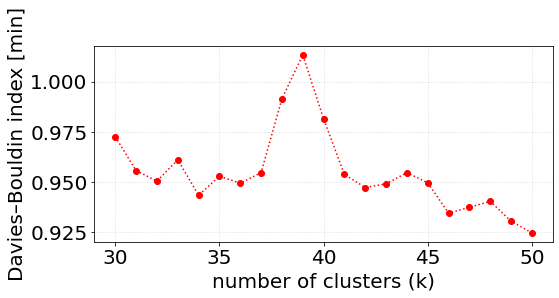

In [24]:
matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()

In [25]:
# visualize 41, otherwise, if not tight enough another much larger like 100

# 6. informative cell

In [26]:
import scipy

# M is the population size
# n is the number of successes in the population 
# N is the sample size (previously n)
# x is still the number of drawn “successes”

# M is the total number of targets in Dorothea
# n is the number of targets of a particular TF in Dorothea
# N is the size of DETs
# x is the number of DETs that are targets of a particular TF

M = 20000
n = 200

N = 1000
x = 20 # 10 would be the same ratio


print('p-value <= ' + str(x) + ': ' + str(scipy.stats.hypergeom.cdf(x, M, n, N)))
print('p-value >= ' + str(x)  + ': ' + str(scipy.stats.hypergeom.sf(x-1, M, n, N)))

p-value <= 20: 0.9989104333089479
p-value >= 20: 0.0025301883214874205
